In [ ]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
import seaborn as sns
from calendar import month_name
from sklearn.preprocessing import MinMaxScaler
#import warnings
#warnings.filterwarnings('ignore')
from sklearn.impute import KNNImputer
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

### Distances
*   lead time ['lead_time']
*   booking frequency ['is_repeated_guest', 'previous_cancellations','previous_bookings_not_canceled', 'booking_changes']
*   travel companions ['adults', 'children', 'babies', 'total_num_people']
*   product value / cancellation fees ['adr', 'market_Complementary', 'deposit_No Deposity', 'deposit_Non Refund', 'deposit_refundable']

In [ ]:
hotel3 = pd.read_csv('drive/MyDrive/hotel3.csv')

In [ ]:
dist = hotel3[['is_canceled', 'lead_time', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'adults', 'children', 'babies', 'total_num_people', 'adr', 'market_Complementary', 'deposit_No Deposit', 'deposit_Non Refund', 'deposit_Refundable']]

In [ ]:
# split data
X, y = dist.iloc[:,1:], dist.iloc[:,0]
total_data = len(X.index)
split = round(total_data*0.8)
X_train = X.iloc[:split, :]
X_test = X.iloc[split:, :]
y_train = y.iloc[:split]
y_test = y.iloc[split:]

In [ ]:
# Imputation (feature = agent)
#https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/
imputer = KNNImputer()
imputer.fit(X_train)
X_trans = imputer.transform(X_train)

In [ ]:
print('missing: %d' % sum(np.isnan(X_trans).flatten()))

missing: 0


In [ ]:
# Data Normalization
# https://machinelearningmastery.com/data-preparation-without-data-leakage/
scaler = MinMaxScaler()
scaler.fit(X_trans)
X_train = scaler.transform(X_trans)


In [ ]:
dtrain = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns.tolist())

### Training 

In [ ]:
# Hyperparameters
# lr = [0.0001, 0.001, 0.1, 0.3]
'''
lr = [0.001, 0.1]
depth = [i for i in np.arange(5, 25, 5)]
child_weight = [i for i in range(0, 1, 3, 5)]
sample_ratio = [i/10 for i in range(4, 8)]
tree_ratio = [i/10 for i in range(4, 8)]
'''
lr = [0.001, 0.1]
depth = [20, 25]
child_weight = [0, 1]
sample_ratio = 0.4
tree_ratio = [0.8, 0.9, 1]

In [ ]:
results = []
for l in lr:
    for d in depth:
        for w in child_weight:
            for trees in tree_ratio:
                # hyperparameters
                params = {'eta':l, 
                          'max_depth': d, 
                          'min_child_weight': w,
                          'subsample': sample_ratio,
                          'colsample_bytree': trees,
                          'scale_pos_weight': 2,
                          'tree_method': 'gpu_hist'}
                print(params)
                # cross validation
                cv_hist = xgb.cv(params, 
                                dtrain, 
                                num_boost_round=1000, 
                                nfold=10, 
                                stratified=True, 
                                metrics=['auc','error'], 
                                early_stopping_rounds=5, 
                                verbose_eval=5, 
                                seed=42)
                # average result 
                train_error = cv_hist.iloc[-1,2]
                train_auc = cv_hist.iloc[-1,0]
                test_error = cv_hist.iloc[-1,-2]
                test_auc = cv_hist.iloc[-1,4]
                results.append([[l, d, w, sample_ratio, trees], [train_error,test_error, train_auc, test_auc]])

{'eta': 0.001, 'max_depth': 20, 'min_child_weight': 0, 'subsample': 0.4, 'colsample_bytree': 0.8, 'scale_pos_weight': 2, 'tree_method': 'gpu_hist'}
[0]	train-auc:0.776458+0.00202753	train-error:0.335836+0.00893702	test-auc:0.751883+0.00439247	test-error:0.353415+0.00906574
[5]	train-auc:0.879775+0.00178243	train-error:0.214668+0.00327097	test-auc:0.816718+0.00286799	test-error:0.268549+0.00536376
[10]	train-auc:0.895905+0.00120795	train-error:0.199564+0.00293368	test-auc:0.824963+0.00383952	test-error:0.260496+0.00519911
[15]	train-auc:0.898685+0.00125295	train-error:0.196926+0.00218179	test-auc:0.82753+0.00335392	test-error:0.259857+0.00320811
[20]	train-auc:0.902388+0.00108282	train-error:0.193708+0.00216011	test-auc:0.82884+0.00383035	test-error:0.258736+0.00367688
{'eta': 0.001, 'max_depth': 20, 'min_child_weight': 0, 'subsample': 0.4, 'colsample_bytree': 0.9, 'scale_pos_weight': 2, 'tree_method': 'gpu_hist'}
[0]	train-auc:0.837559+0.00265905	train-error:0.259226+0.00531012	test-au

In [ ]:
#{'eta': 0.001, 'max_depth': 25, 'min_child_weight': 0,1, 'subsample': 0.4, 'colsample_bytree': 0.8, 'scale_pos_weight': 2, 'tree_method': 'gpu_hist'} 
# train-auc:0.930275+0.000840642	train-error:0.149969+0.00146609	test-auc:0.832536+0.00381599	test-error:0.245363+0.00448407
#{'eta': 0.1, 'max_depth': 25, 'min_child_weight': 0, 'subsample': 0.4, 'colsample_bytree': 0.9, 'scale_pos_weight': 2, 'tree_method': 'gpu_hist'}
#train-auc:0.973349+0.000408522	train-error:0.0911116+0.00105776	test-auc:0.823241+0.00251206	test-error:0.244369+0.0033436

In [ ]:
result_np = np.array(results)
result = pd.DataFrame(result_np, columns=['parameters', 'validation results'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
result[['eta', 'max_depth', 'min_child_weight', 'subsample', 'colsample_bytree']] = result['parameters'].apply(pd.Series)
result[['train_error', 'test_error', 'train_auc', 'test_auc']] = result['validation results'].apply(pd.Series)
result.drop(columns=['parameters', 'validation results'], inplace=True)

In [ ]:
best_params = result.sort_values(['test_error']).iloc[0,:5]
print(best_params.to_list())
best_result = result.sort_values(['test_error']).iloc[0,5:]
print(best_result.to_list())

[0.1, 25.0, 0.0, 0.4, 0.9]
[0.09111159999999999, 0.2443686, 0.9733487999999999, 0.8232407]


In [ ]:
# {'eta': 0.1, 'max_depth': 25, 'min_child_weight': 0, 'subsample': 0.4, 'colsample_bytree': 0.9} reaches lowest test-error 
# gamma [0,1,3,5] has no effect on the model performance, therefore set as default

In [ ]:
# build final model
# best_params
params = {'eta':best_params[0], 
          'max_depth': int(best_params[1]), 
          'min_child_weight': best_params[2],
          'subsample': best_params[3],
          'colsample_bytree': best_params[4],
          'scale_pos_weight': 2,
          'tree_method': 'gpu_hist',
          'eval_metric': ['auc', 'error'],
          'seed':42}
print(params)

epochs = 100

bst = xgb.train(params, 
                dtrain, 
                epochs, 
                [(dtrain, 'train')],
                early_stopping_rounds=5, 
                verbose_eval=2)

{'eta': 0.1, 'max_depth': 25, 'min_child_weight': 0.0, 'subsample': 0.4, 'colsample_bytree': 0.9, 'scale_pos_weight': 2, 'tree_method': 'gpu_hist', 'eval_metric': ['auc', 'error'], 'seed': 42}
[0]	train-auc:0.851755	train-error:0.228074
Multiple eval metrics have been passed: 'train-error' will be used for early stopping.

Will train until train-error hasn't improved in 5 rounds.
[2]	train-auc:0.892459	train-error:0.19207
[4]	train-auc:0.903862	train-error:0.1792
[6]	train-auc:0.920245	train-error:0.161816
[8]	train-auc:0.929655	train-error:0.151794
[10]	train-auc:0.936157	train-error:0.144412
[12]	train-auc:0.941437	train-error:0.137448
[14]	train-auc:0.945327	train-error:0.133667
[16]	train-auc:0.949208	train-error:0.127258
[18]	train-auc:0.951892	train-error:0.123802
[20]	train-auc:0.95219	train-error:0.124064
[22]	train-auc:0.95309	train-error:0.123038
[24]	train-auc:0.954265	train-error:0.121299
[26]	train-auc:0.956201	train-error:0.118702
[28]	train-auc:0.957586	train-error:0.116

In [ ]:
X_test_trans = imputer.transform(X_test)
X_test = scaler.transform(X_test_trans)
dtest = xgb.DMatrix(data=X_test, label=y_test, feature_names=X.columns.tolist())

In [ ]:
y_train_preds = np.round(bst.predict(dtrain, ntree_limit=bst.best_ntree_limit))
y_preds = np.round(bst.predict(dtest, ntree_limit=bst.best_ntree_limit))

In [ ]:
print(classification_report(y_train,y_train_preds,target_names=['not_canceled', 'canceled']))
print(classification_report(y_test,y_preds,target_names=['not_canceled', 'canceled']))

              precision    recall  f1-score   support

not_canceled       0.95      0.91      0.93     59625
    canceled       0.86      0.92      0.89     35866

    accuracy                           0.91     95491
   macro avg       0.90      0.91      0.91     95491
weighted avg       0.91      0.91      0.91     95491

              precision    recall  f1-score   support

not_canceled       0.82      0.90      0.86     15525
    canceled       0.77      0.63      0.70      8348

    accuracy                           0.81     23873
   macro avg       0.80      0.77      0.78     23873
weighted avg       0.80      0.81      0.80     23873



In [ ]:
roc_auc_score(y_test, y_preds)

0.7664635343245164

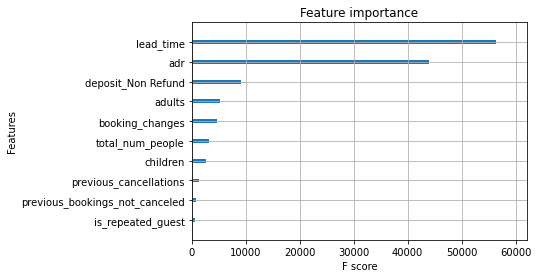

In [ ]:
xgb.plot_importance(bst, importance_type='total_gain', max_num_features=10, show_values=False)

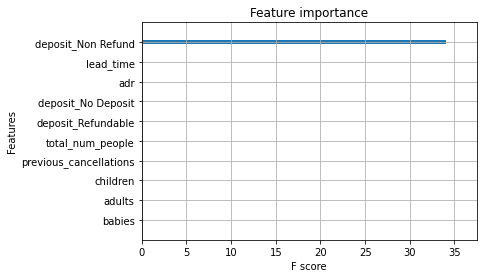

In [ ]:
xgb.plot_importance(bst, importance_type='gain', max_num_features=10, show_values=False)

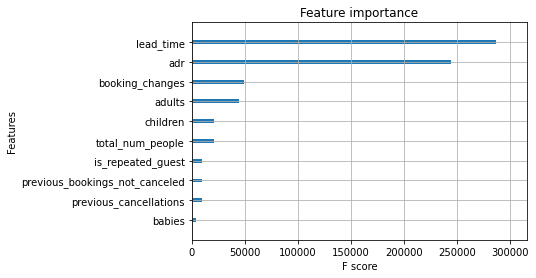

In [ ]:
xgb.plot_importance(bst, importance_type='weight', max_num_features=10, show_values=False)

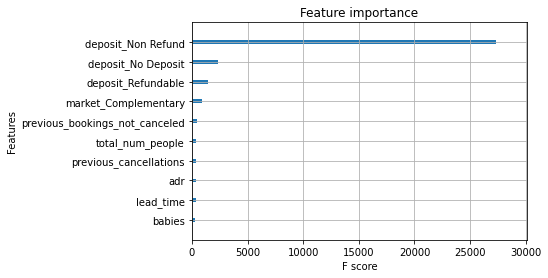

In [ ]:
xgb.plot_importance(bst, importance_type='cover', max_num_features=10, show_values=False)

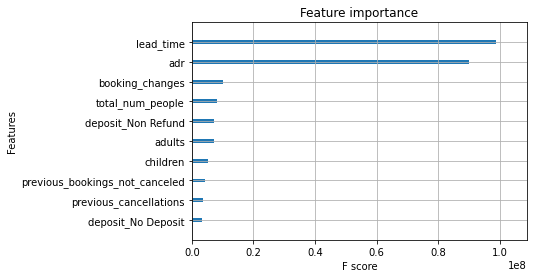

In [ ]:
xgb.plot_importance(bst, importance_type='total_cover', max_num_features=10, show_values=False)